In [ ]:
!pip install transformers sentencepiece datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.nn import functional as f
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

/usr/local/lib/python3.10/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [ ]:
model_repo = 'google/mt5-small'
tokenizer = AutoTokenizer.from_pretrained(model_repo)
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()
max_seq_len = model.config.max_length

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
dataset = load_dataset('alt')

Generating train split:   0%|          | 0/18088 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1019 [00:00<?, ? examples/s]

Dataset alt downloaded and prepared to /root/.cache/huggingface/datasets/alt/alt-parallel/1.0.0/b498af66d7e1b78d98b7557e7b0b06ae54fc60491dccdc1a0f8316e677d1ce75. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'ja': '<jp>',
    'zh': '<zh>'
}

In [ ]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)

  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)

    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [ ]:
in_ids, out_ids = format_translation_data(
    train_dataset[1]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

▁< en > 安 德里 亚 · 马 西 在 第四 分钟 成功 达 阵 , 意大利 率先 得分 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁Andrea ▁Masi ▁ opened ▁the ▁scor ing ▁in ▁the ▁four th ▁minute ▁with ▁ a ▁try ▁for ▁Italy . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

### Training the Model

In [ ]:
n_epochs = 10
batch_size = 32
print_freq = 50
lr = 0.001
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [ ]:
losses = []


In [ ]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
test_loss = eval_model(model, test_dataset)
test_loss

3.082544684410095

In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):

    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

  test_loss = eval_model(model, test_dataset)
  print('Test loss of {:.3f}'.format(test_loss))

<ipython-input-23-af7359d022ce>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 2.896 | lr: 0.0008928571428571429
Epoch: 1 | Step: 100 | Avg. loss: 3.328 | lr: 0.0009921484653818702
Epoch: 1 | Step: 150 | Avg. loss: 3.200 | lr: 0.000983226266952177
Epoch: 1 | Step: 200 | Avg. loss: 3.056 | lr: 0.000974304068522484
Epoch: 1 | Step: 250 | Avg. loss: 3.014 | lr: 0.0009653818700927909
Epoch: 1 | Step: 300 | Avg. loss: 3.025 | lr: 0.0009564596716630978
Epoch: 1 | Step: 350 | Avg. loss: 2.982 | lr: 0.0009475374732334048
Epoch: 1 | Step: 400 | Avg. loss: 2.921 | lr: 0.0009386152748037116
Epoch: 1 | Step: 450 | Avg. loss: 2.945 | lr: 0.0009296930763740185
Epoch: 1 | Step: 500 | Avg. loss: 2.926 | lr: 0.0009207708779443254
Epoch: 1 | Step: 550 | Avg. loss: 2.920 | lr: 0.0009118486795146324
Test loss of 3.195


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg. loss: 2.698 | lr: 0.0009000713775874376
Epoch: 2 | Step: 100 | Avg. loss: 2.710 | lr: 0.0008911491791577446
Epoch: 2 | Step: 150 | Avg. loss: 2.713 | lr: 0.0008822269807280515
Epoch: 2 | Step: 200 | Avg. loss: 2.715 | lr: 0.0008733047822983583
Epoch: 2 | Step: 250 | Avg. loss: 2.728 | lr: 0.0008643825838686653
Epoch: 2 | Step: 300 | Avg. loss: 2.715 | lr: 0.0008554603854389722
Epoch: 2 | Step: 350 | Avg. loss: 2.706 | lr: 0.0008465381870092791
Epoch: 2 | Step: 400 | Avg. loss: 2.710 | lr: 0.000837615988579586
Epoch: 2 | Step: 450 | Avg. loss: 2.724 | lr: 0.000828693790149893
Epoch: 2 | Step: 500 | Avg. loss: 2.694 | lr: 0.0008197715917201999
Epoch: 2 | Step: 550 | Avg. loss: 2.720 | lr: 0.0008108493932905068
Test loss of 3.056


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 3 | Step: 50 | Avg. loss: 2.498 | lr: 0.0007990720913633119
Epoch: 3 | Step: 100 | Avg. loss: 2.515 | lr: 0.0007901498929336188
Epoch: 3 | Step: 150 | Avg. loss: 2.489 | lr: 0.0007812276945039258
Epoch: 3 | Step: 200 | Avg. loss: 2.489 | lr: 0.0007723054960742327
Epoch: 3 | Step: 250 | Avg. loss: 2.497 | lr: 0.0007633832976445396
Epoch: 3 | Step: 300 | Avg. loss: 2.496 | lr: 0.0007544610992148465
Epoch: 3 | Step: 350 | Avg. loss: 2.481 | lr: 0.0007455389007851535
Epoch: 3 | Step: 400 | Avg. loss: 2.506 | lr: 0.0007366167023554604
Epoch: 3 | Step: 450 | Avg. loss: 2.478 | lr: 0.0007276945039257673
Epoch: 3 | Step: 500 | Avg. loss: 2.495 | lr: 0.0007187723054960742
Epoch: 3 | Step: 550 | Avg. loss: 2.498 | lr: 0.0007098501070663812
Test loss of 3.009


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 4 | Step: 50 | Avg. loss: 2.313 | lr: 0.0006980728051391863
Epoch: 4 | Step: 100 | Avg. loss: 2.298 | lr: 0.0006891506067094932
Epoch: 4 | Step: 150 | Avg. loss: 2.348 | lr: 0.0006802284082798001
Epoch: 4 | Step: 200 | Avg. loss: 2.332 | lr: 0.000671306209850107
Epoch: 4 | Step: 250 | Avg. loss: 2.337 | lr: 0.000662384011420414
Epoch: 4 | Step: 300 | Avg. loss: 2.320 | lr: 0.0006534618129907209
Epoch: 4 | Step: 350 | Avg. loss: 2.316 | lr: 0.0006445396145610278
Epoch: 4 | Step: 400 | Avg. loss: 2.336 | lr: 0.0006356174161313347
Epoch: 4 | Step: 450 | Avg. loss: 2.332 | lr: 0.0006266952177016417
Epoch: 4 | Step: 500 | Avg. loss: 2.326 | lr: 0.0006177730192719486
Epoch: 4 | Step: 550 | Avg. loss: 2.324 | lr: 0.0006088508208422555
Test loss of 2.913


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 5 | Step: 50 | Avg. loss: 2.120 | lr: 0.0005970735189150607
Epoch: 5 | Step: 100 | Avg. loss: 2.128 | lr: 0.0005881513204853676
Epoch: 5 | Step: 150 | Avg. loss: 2.146 | lr: 0.0005792291220556746
Epoch: 5 | Step: 200 | Avg. loss: 2.190 | lr: 0.0005703069236259815
Epoch: 5 | Step: 250 | Avg. loss: 2.133 | lr: 0.0005613847251962884
Epoch: 5 | Step: 300 | Avg. loss: 2.149 | lr: 0.0005524625267665953
Epoch: 5 | Step: 350 | Avg. loss: 2.177 | lr: 0.0005435403283369023
Epoch: 5 | Step: 400 | Avg. loss: 2.221 | lr: 0.0005346181299072092
Epoch: 5 | Step: 450 | Avg. loss: 2.148 | lr: 0.0005256959314775161
Epoch: 5 | Step: 500 | Avg. loss: 2.164 | lr: 0.0005167737330478231
Epoch: 5 | Step: 550 | Avg. loss: 2.169 | lr: 0.00050785153461813
Test loss of 2.986


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 6 | Step: 50 | Avg. loss: 1.997 | lr: 0.0004960742326909351
Epoch: 6 | Step: 100 | Avg. loss: 2.023 | lr: 0.000487152034261242
Epoch: 6 | Step: 150 | Avg. loss: 1.994 | lr: 0.0004782298358315489
Epoch: 6 | Step: 200 | Avg. loss: 2.029 | lr: 0.0004693076374018558
Epoch: 6 | Step: 250 | Avg. loss: 2.019 | lr: 0.0004603854389721627
Epoch: 6 | Step: 300 | Avg. loss: 2.024 | lr: 0.00045146324054246966
Epoch: 6 | Step: 350 | Avg. loss: 2.022 | lr: 0.00044254104211277655
Epoch: 6 | Step: 400 | Avg. loss: 2.038 | lr: 0.0004336188436830835
Epoch: 6 | Step: 450 | Avg. loss: 2.018 | lr: 0.00042469664525339045
Epoch: 6 | Step: 500 | Avg. loss: 2.039 | lr: 0.00041577444682369734
Epoch: 6 | Step: 550 | Avg. loss: 2.041 | lr: 0.0004068522483940043
Test loss of 2.920


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 7 | Step: 50 | Avg. loss: 1.862 | lr: 0.0003950749464668094
Epoch: 7 | Step: 100 | Avg. loss: 1.882 | lr: 0.00038615274803711637
Epoch: 7 | Step: 150 | Avg. loss: 1.874 | lr: 0.00037723054960742326
Epoch: 7 | Step: 200 | Avg. loss: 1.863 | lr: 0.0003683083511777302
Epoch: 7 | Step: 250 | Avg. loss: 1.892 | lr: 0.0003593861527480371
Epoch: 7 | Step: 300 | Avg. loss: 1.858 | lr: 0.00035046395431834404
Epoch: 7 | Step: 350 | Avg. loss: 1.881 | lr: 0.000341541755888651
Epoch: 7 | Step: 400 | Avg. loss: 1.889 | lr: 0.0003326195574589579
Epoch: 7 | Step: 450 | Avg. loss: 1.863 | lr: 0.00032369735902926483
Epoch: 7 | Step: 500 | Avg. loss: 1.897 | lr: 0.0003147751605995717
Epoch: 7 | Step: 550 | Avg. loss: 1.860 | lr: 0.00030585296216987867
Test loss of 2.985


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 8 | Step: 50 | Avg. loss: 1.738 | lr: 0.0002940756602426838
Epoch: 8 | Step: 100 | Avg. loss: 1.738 | lr: 0.00028515346181299075
Epoch: 8 | Step: 150 | Avg. loss: 1.741 | lr: 0.00027623126338329764
Epoch: 8 | Step: 200 | Avg. loss: 1.766 | lr: 0.0002673090649536046
Epoch: 8 | Step: 250 | Avg. loss: 1.742 | lr: 0.00025838686652391153
Epoch: 8 | Step: 300 | Avg. loss: 1.730 | lr: 0.0002494646680942184
Epoch: 8 | Step: 350 | Avg. loss: 1.757 | lr: 0.00024054246966452534
Epoch: 8 | Step: 400 | Avg. loss: 1.762 | lr: 0.00023162027123483226
Epoch: 8 | Step: 450 | Avg. loss: 1.784 | lr: 0.00022269807280513918
Epoch: 8 | Step: 500 | Avg. loss: 1.795 | lr: 0.00021377587437544613
Epoch: 8 | Step: 550 | Avg. loss: 1.745 | lr: 0.00020485367594575305
Test loss of 2.992


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 9 | Step: 50 | Avg. loss: 1.612 | lr: 0.00019307637401855818
Epoch: 9 | Step: 100 | Avg. loss: 1.636 | lr: 0.0001841541755888651
Epoch: 9 | Step: 150 | Avg. loss: 1.642 | lr: 0.00017523197715917202
Epoch: 9 | Step: 200 | Avg. loss: 1.642 | lr: 0.00016630977872947894
Epoch: 9 | Step: 250 | Avg. loss: 1.622 | lr: 0.00015738758029978586
Epoch: 9 | Step: 300 | Avg. loss: 1.643 | lr: 0.00014846538187009278
Epoch: 9 | Step: 350 | Avg. loss: 1.669 | lr: 0.0001395431834403997
Epoch: 9 | Step: 400 | Avg. loss: 1.582 | lr: 0.00013062098501070662
Epoch: 9 | Step: 450 | Avg. loss: 1.653 | lr: 0.00012169878658101357
Epoch: 9 | Step: 500 | Avg. loss: 1.672 | lr: 0.00011277658815132049
Epoch: 9 | Step: 550 | Avg. loss: 1.652 | lr: 0.00010385438972162742
Test loss of 2.996


  0%|          | 0/566 [00:00<?, ?it/s]

Epoch: 10 | Step: 50 | Avg. loss: 1.529 | lr: 9.207708779443255e-05
Epoch: 10 | Step: 100 | Avg. loss: 1.548 | lr: 8.315488936473947e-05
Epoch: 10 | Step: 150 | Avg. loss: 1.539 | lr: 7.423269093504639e-05
Epoch: 10 | Step: 200 | Avg. loss: 1.565 | lr: 6.531049250535331e-05
Epoch: 10 | Step: 250 | Avg. loss: 1.510 | lr: 5.638829407566024e-05
Epoch: 10 | Step: 300 | Avg. loss: 1.549 | lr: 4.746609564596717e-05
Epoch: 10 | Step: 350 | Avg. loss: 1.568 | lr: 3.854389721627409e-05
Epoch: 10 | Step: 400 | Avg. loss: 1.531 | lr: 2.9621698786581015e-05
Epoch: 10 | Step: 450 | Avg. loss: 1.552 | lr: 2.0699500356887938e-05
Epoch: 10 | Step: 500 | Avg. loss: 1.537 | lr: 1.1777301927194862e-05
Epoch: 10 | Step: 550 | Avg. loss: 1.551 | lr: 2.8551034975017847e-06
Test loss of 2.960


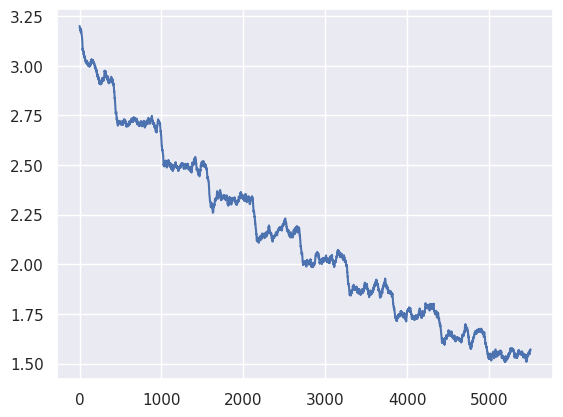

In [ ]:
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

### Testing

In [ ]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'zh',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.
Truncated input text: <zh>It has been confirmed that eight thoroughbred race horses at Randwick</s>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

今天早些时候,在兰登威尔的8只野马跑道的
今天早些时候,在兰登威尔的8只野马赛马的
今天早些时候,在兰登威尔的8只野马运动员在


In [ ]:
#@title The Translator
input_text = 'Jackson became the president.' #@param {type:"string"}
output_language = 'zh' #@param ["en", "ja", "zh"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

Jackson became the president.  ->  杰克逊成为总统。
